# 1. Como executar
Para executar esse notebook com CPU ou GPU siga os passos abaixo:

Caso esteja rodando localmente execute o comando pip install -r requirements.txt para download de todas as dependências necessárias e vá para o passo 4.

1. Baixe este notebook e importe para o Google Colab

2. No menu superior direito do colab, onde está escrito "Conectar" ou "Ligar", clique na seta ao lado e escolha a opção "Alterar o tipo de ambiente de execução"

3. Uma janela será aberta onde você pode escolher entre utilizar CPU ou GPU. Escolha a que deseja utilizar (caso esteja em uma conta gratuita, apenas CPU e a T4 GPU estarão disponíveis). Clique em "OK" caso um pop-up apareça. Dica: GPUs são mais rápidas.

4. Execute a seção Importação de dependências para baixar todas as dependências necessárias.

Pronto! Já está tudo preparado para execução.

<strong>OBS: Caso deseje alterar de CPU para GPU, ou vice-versa, durante a execução, a sessão será reiniciada e tudo deverá ser executado novamente.</strong>

# 2. Importação de Dependências

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
import json
import psutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Leitura dos Dados Processados

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dados/Dados_processados.csv')

# remove empty questions
df = df[df['processed_pergunta'] != '[]']
df.head()

,Intencao,Pergunta,Resposta,processed_pergunta,processed_resposta,perguntas_embedding,respostas_embedding
0,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d...","['dia', 'gostar', 'caixa', 'family', 'Mart', '...","['dia', 'sr', 'utilizar', 'cartão', 'depósito'...",[-0.12652865 -0.21404813 0.6218531 -0.159232...,[-2.18324419e-02 -3.35665882e-01 8.01800370e-...
1,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f...","['enviar', 'dinheiro', 'Japão']","['inscrever', 'serviço', 'remesso', 'baixe', '...",[ 4.54643458e-01 -2.75033295e-01 5.07293880e-...,[ 8.61318335e-02 -2.94515491e-01 6.79131031e-...
2,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ...","['levar', 'beneficiário', 'receber', 'dinheiro']","['via', 'regro', 'remessa', 'ser', 'pago', 'vi...",[ 2.73421943e-01 -1.44251376e-01 5.80531359e-...,[ 4.09347825e-02 -4.39058930e-01 4.94384944e-...
3,"Pedido de envio via metodo ""ByPhone""",Boa tarde\nAcabei de fazer a transferência de ...,iremos processar a sua solicitacao.\nMuito obr...,"['acabar', 'transferência', '22', '23', 'total...","['ir', 'processar', 'solicitacao', 'otimar']",[ 3.93293761e-02 -3.45374376e-01 3.65606606e-...,[ 1.40843421e-01 -4.54451501e-01 5.73175907e-...
4,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao.\nMuito obr...,"['poder', 'remesso', '22yenes', 'bbb', 'rrr', ...","['ir', 'processar', 'solicitacao', 'otimar']",[ 4.56727445e-02 -1.60404086e-01 6.08401418e-...,[ 1.40843421e-01 -4.54451501e-01 5.73175907e-...


In [4]:
def split_intentions(df):
    """
    Makes a unique dataframe for each intention

    Args:
        df (pd.dataframe): dataframe with the database

    Returns:
        list: list of dataframes with each intention
    """

    #sorting intentions
    df_sorted = df.sort_values(by='Intencao')

    #spliting intentions in different DataFrames
    dfs_intentions = []
    for intention in df_sorted['Intencao'].unique():
        dfs_intentions.append(df_sorted[df_sorted['Intencao'] == intention])

    return dfs_intentions

# 4. Bag of Words

## 4.1 Função Bag of Words

In [9]:
def bow(list_of_texts, full_df):
    """
    Creates the Bag of Words (BoW) for the questions in the database

    Args:
        list_of_texts (pd.Series): Column with the questions that will be the lines of the BoW
        full_df (pd.Series): all questions to build the vocabulary

    Returns:
        np.array: array with the BoW
    """
    vectorizer = CountVectorizer()
    vectorizer.fit(full_df)
    vetorized_text = vectorizer.transform(list_of_texts.apply(lambda x: eval(x)).apply(lambda x: ' '.join(x)))

    return vetorized_text.toarray()

## 4.2 Teste Bag of Words

In [127]:
def test_bow():
    """
    Tests the Bag of Words function
    """
    test_df = pd.DataFrame(data={"['enviar', 'dinheiro']", "['atualizar', 'dados', 'cadastrais']"}, columns=['texto'])

    # alphabetical order (['atualizar' 'cadastrais' 'dados' 'dinheiro' 'enviar'])
    expected_output = [[0, 0, 0, 1, 1], [1, 1, 1, 0, 0]]

    vetorized_text = bow(test_df['texto'], test_df['texto'])

    assert (vetorized_text == expected_output).all()
    print("Teste Bag of Words passou!")



In [ ]:
test_bow()

Teste Bag of Words passou!


# 5. Modelo Naive Bayes

In [122]:
class NBModel:
    """
    Naive Bayes Model for classification of intentions
    """
    def __init__(self, full_df):
        self.full_df = full_df
        self.df_train, self.df_test = self.split_data()

    def split_data(self):
        """
        Splits the data into train and test sets

        Returns:
            pd.DataFrame: train and test sets
        """
        df_train = pd.DataFrame(columns=list(self.full_df.columns))
        df_test = pd.DataFrame(columns=list(self.full_df.columns))

        for dataframe in split_intentions(self.full_df):
            if len(dataframe) != 1:
                df_train_intention, df_test_intention = train_test_split(dataframe, test_size=0.3, random_state=42)
                df_train = pd.concat([df_train, df_train_intention], ignore_index=True)
                df_test = pd.concat([df_test, df_test_intention], ignore_index=True)

        df_train = df_train.sample(frac=1).reset_index(drop=True)
        df_test = df_test.sample(frac=1).reset_index(drop=True)

        return df_train, df_test

    def train_model(self):
        """
        Trains the model
        """
        self.model = MultinomialNB()
        self.model.fit(bow(self.df_train['processed_pergunta'], self.full_df['processed_pergunta']), self.df_train['Intencao'])

    def prediction_model_train(self):
        """
        Makes the predictions for the train set

        Returns:
            str: metrics
            np.array: confusion matrix
        """
        prediction = self.model.predict(bow(self.df_train['processed_pergunta'], self.full_df['processed_pergunta']))
        metrics = classification_report(self.df_train['Intencao'], prediction)
        matrix = confusion_matrix(self.df_train['Intencao'], prediction)

        return metrics, matrix

    def prediction_model_validation(self):
        """
        Makes the predictions for the test set

        Returns:
            str: metrics
            np.array: confusion matrix
        """
        prediction = self.model.predict(bow(self.df_test['processed_pergunta'], self.full_df['processed_pergunta']))
        metrics = classification_report(self.df_test['Intencao'], prediction, zero_division=0.0)
        matrix = confusion_matrix(self.df_test['Intencao'], prediction)

        return metrics, matrix

In [123]:
nb_model = NBModel(df)

## 5.1 Testes unitários

In [108]:
class Tests:
    """
    Tests for the Naive Bayes Model
    """
    def __init__(self, df):
        self.df = df
        self.model = NBModel(self.df)
        self.model.train_model()

    def test_model_training(self):
        assert hasattr(self.model.model, "class_count_")
        print('Modelo treinado com sucesso!')

    def test_model_integration(self):
        metrics, matrix = self.model.prediction_model_validation()
        assert matrix.shape == (17, 17)
        print('O modelo apresenta a correta quantidade de classes preditas!')

    def probability_test(self):

        probabilities = self.model.model.predict_proba(bow(self.df['processed_pergunta'], self.df['processed_pergunta']))

        for probability in probabilities:
            assert round(sum(probability)) == 1
        print('Probabilidades de cada categoria somam 100%!')

In [114]:
test = Tests(df)

test.test_model_training()
test.test_model_integration()
test.probability_test()

Modelo treinado com sucesso!
O modelo apresenta a correta quantidade de classes preditas!
Probabilidades de cada categoria somam 100%!


## 5.2 Treinamento

In [125]:
nb_model.train_model()

## 5.3 Validação do treinamento

As métricas de avaliação escolhidas para medir o desempenho do modelo foram a Matriz de Confusão combinada com as métricas de Precisão, Acurácia, Recall e F1-Score. Cada uma dessas métricas foi escolhida por sua capacidade de fornecer insights específicos sobre o comportamento do modelo.

Matriz de Confusão: Fornece uma visão detalhada sobre como as classes estão sendo classificadas, permitindo identificar quais classes são mais confundidas entre si (SCIKIT-LEARN. sklearn.metrics.confusion_matrix)

Precisão: Mede a proporção de classificações corretas entre todas as predições feitas para uma classe específica. É particularmente importante em cenários onde os falsos positivos podem ter um impacto negativo significativo (SCIKIT-LEARN. precision_score).

Acurácia: Mdida para quantificar o nível de erro entre um valor desejado, ideal, e um valor real ou medido. Ela é calculada dividindo o número de previsões corretas pelo número total de previsões, e serve para identificar a taxa de acerto (SCIKIT-LEARN. accuracy_score).

Recall: Mede a capacidade do modelo de prever classes positivas reais. É a taxa entre os verdadeiros positivos previstos e o que foi realmente marcado. A métrica de recall revelam quantas das classes previstas estão corretas, e é importante para garantir que o modelo esteja prevendo corretamente (SCIKIT-LEARN, recall_score).

F1-Score: A métrica equilibra as métricas de precisão e recall. Ela é especialmente útil quando há um desequilíbrio entre as classes ou quando é necessário um trade-off entre precisão e recall (SCIKIT-LEARN. sklearn.metrics.f1_score).

Referências:

SCIKIT-LEARN. precision_score. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#precision-score. Acesso em: 28 ago. 2024.

SCIKIT-LEARN. accuracy_score. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#accuracy-score. Acesso em: 28 ago. 2024.

SCIKIT-LEARN recall_score. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#recall-score. Acesso em: 28 ago. 2024.

SCIKIT-LEARN. sklearn.metrics.f1_score — scikit-learn 0.21.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html. Acesso em: 28 ago. 2024.

### 5.3.1 Análise de desempenho da fase de treino

In [126]:
metrics_train, cm_train = nb_model.prediction_model_train()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 5.3.1.1 Matriz de confusão

A Matriz de Confusão é uma forma gráfica de representar o desempenho do modelo na fase de teste. Nela podemos ver as verdadeiras classes por meio das linhas e as classes preditas pelo modelo por meio das colunas.
Os valores da matriz representam a quantidade de vezes que ao tentar predizer a classe daquela linha a resposta foi a classe da coluna. Dessa forma, a diagonal principal representa os valores preditos de forma correta (verdadeiros positivo).

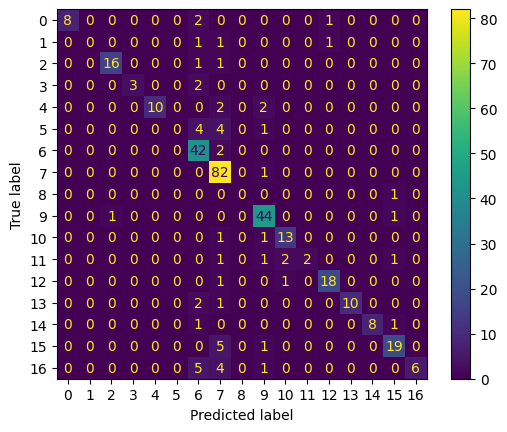

In [117]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)

disp.plot()

plt.show()

#### 5.3.1.2 Métricas da fase de treino

In [118]:
print(metrics_train)

                                      precision    recall  f1-score   support

                      Acesso a conta       1.00      0.73      0.84        11
     Atualizacao de dados cadastrais       0.00      0.00      0.00         3
            Cadastro de beneficiario       0.94      0.89      0.91        18
                        Cancelamento       1.00      0.60      0.75         5
                      Como depositar       1.00      0.71      0.83        14
                  Como fazer remessa       0.00      0.00      0.00         9
                   Como se inscrever       0.70      0.95      0.81        44
         Confirmacao de cambio/taxas       0.78      0.99      0.87        83
              Envio via Deposit Code       0.00      0.00      0.00         1
Pedido de envio via metodo "ByPhone"       0.85      0.96      0.90        46
                Problemas de remessa       0.81      0.87      0.84        15
                           Reembolso       1.00      0.29      

### 5.3.2 Análise de desempenho da fase de teste

In [119]:
metrics_test, cm_test = nb_model.prediction_model_validation()

### 5.3.2.1 Matriz de Confusão

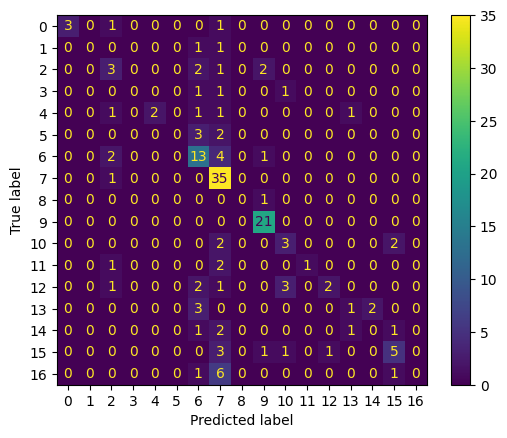

In [120]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)

disp.plot()

plt.show()

### 5.3.2.2 Métricas da Validação

In [121]:
print(metrics_test)

                                      precision    recall  f1-score   support

                      Acesso a conta       1.00      0.60      0.75         5
     Atualizacao de dados cadastrais       0.00      0.00      0.00         2
            Cadastro de beneficiario       0.30      0.38      0.33         8
                        Cancelamento       0.00      0.00      0.00         3
                      Como depositar       1.00      0.33      0.50         6
                  Como fazer remessa       0.00      0.00      0.00         5
                   Como se inscrever       0.46      0.65      0.54        20
         Confirmacao de cambio/taxas       0.56      0.97      0.71        36
              Envio via Deposit Code       0.00      0.00      0.00         1
Pedido de envio via metodo "ByPhone"       0.81      1.00      0.89        21
                Problemas de remessa       0.38      0.43      0.40         7
                           Reembolso       1.00      0.25      

## 5.4 Conclusão das análises

Por meio da matriz de confusão plotada com base no desempenho da fase de teste, vemos que o modelo apresenta uma grande concentração de predições na classe Confirmação de câmbio/taxas, representada pelo número 7.

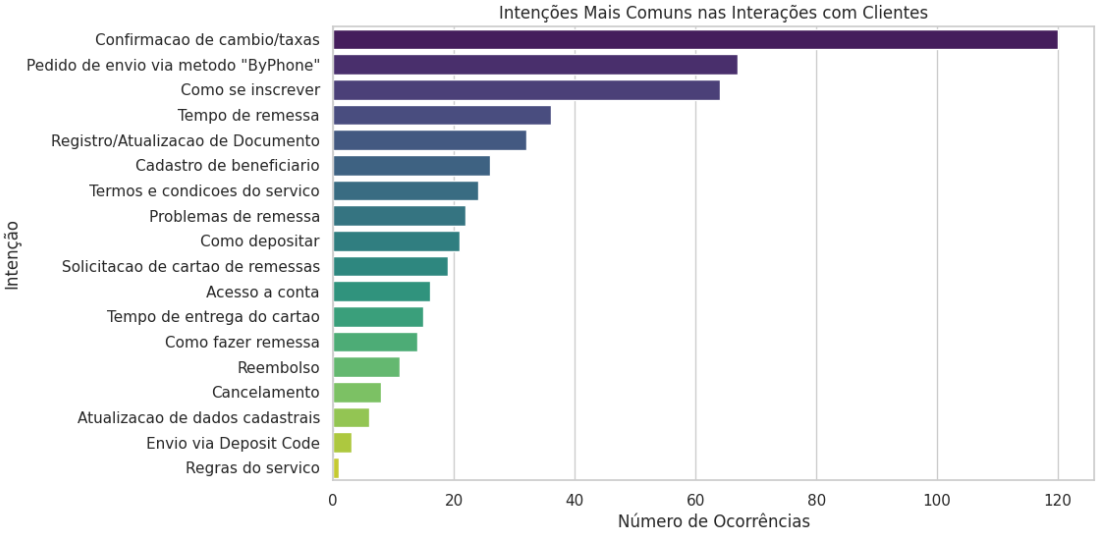

Ao analisarmos o gráfico de número de peguntas por intenção, vemos que esta classe respondida várias vezes pelo modelo, é a classe que mais apresentou exemplos no dataset de treino. Portanto, esse desbalanceamento provavelmente causa com que o modelo tenha uma pré-disposição em dizer as classes com mais representação, mesmo com que isso seja uma resposta equivocada. Pela mesma razão, vemos que o modelo não arriscou responder nenhuma vez as classes de menor quantidade de exemplos, são elas: Atualizacao de dados cadastrais, Cancelamento, Como fazer remessa, Envio via Deposit Code e Termos e condicoes do servico, representadas pelos números 1, 3, 5, 8 e 16.

Os argumentos podem ser comprovados por meio da matriz de confusão com base na fase de treino, pois ela aprensenta grandes acertos, visto uma alta quantidade de valores na diagonal principal. Desta forma, concluimos que o modelo acabou se enviesando para as classes de maior quantidade de ocorrências

# 6. Análise CPU x GPU

In [ ]:
root_dir = "/content/drive/MyDrive/Dados/"
try:
    with open(root_dir + "execution_times.json", "r") as f:
        data = json.load(f)
except FileNotFoundError:
    data = {}

In [ ]:
def memory_usage_psutil():
    """
        Returns the memory usage of the process in MB
    """
    try:
      process = psutil.Process()
      mem = process.memory_info().rss / float(2 ** 20)  # em MB
      return mem
    except Exception as e:
        print(f"Erro ao calcular a memória: {e}")
        raise

## 6.1 CPU

In [ ]:
num_samples = 10

all_times = 0
all_mem = 0

for i in range(num_samples):
    cpu_nb_model = NBModel(df)

    cpu_start_time = time.time()
    cpu_start_mem = memory_usage_psutil()

    cpu_nb_model.train_model()
    cpu_nb_model.test_model()

    cpu_mem = memory_usage_psutil() - cpu_start_mem

    cpu_time = time.time() - cpu_start_time

    all_times += cpu_time
    all_mem += cpu_mem

cpu_time = all_times / num_samples
cpu_mem = all_mem / num_samples

data["CPU"] = {
    "execution_time": cpu_time,
    "memory_usage": cpu_mem
}

with open(root_dir + "execution_times.json", "w") as f:
    json.dump(data, f)

print("Dados salvos")

## 6.2 T4 GPU

In [ ]:
num_samples = 10

all_times = 0
all_mem = 0

for i in range(num_samples):
    t4_nb_model = NBModel(df)

    t4_start_time = time.time()
    t4_start_mem = memory_usage_psutil()

    t4_nb_model.train_model()
    t4_nb_model.test_model()

    t4_mem = memory_usage_psutil() - t4_start_mem

    t4_time = time.time() - t4_start_time
    all_times += t4_time
    all_mem += t4_mem

t4_time = all_times / num_samples
t4_mem = all_mem / num_samples

data["T4 GPU"] = {
    "execution_time": t4_time,
    "memory_usage": t4_mem
}

with open(root_dir + "execution_times.json", "w") as f:
    json.dump(data, f)

print("Dados salvos")

## 6.3 A100 GPU

In [ ]:
num_samples = 10

all_times = 0
all_mem = 0

for i in range(num_samples):
    a100_nb_model = NBModel(df)

    a100_start_time = time.time()
    a100_start_mem = memory_usage_psutil()

    a100_nb_model.train_model()
    a100_nb_model.test_model()

    a100_mem = memory_usage_psutil() - a100_start_mem

    a100_time = time.time() - a100_start_time

    all_times += a100_time
    all_mem += a100_mem

a100_time = all_times / num_samples
a100_mem = all_mem / num_samples

data["A100 GPU"] = {
    "execution_time": a100_time,
    "memory_usage": a100_mem
}

with open(root_dir + "execution_times.json", "w") as f:
    json.dump(data, f)

print("Dados salvos")

## 6.4 Análise

### 6.4.1 Tempo de execução

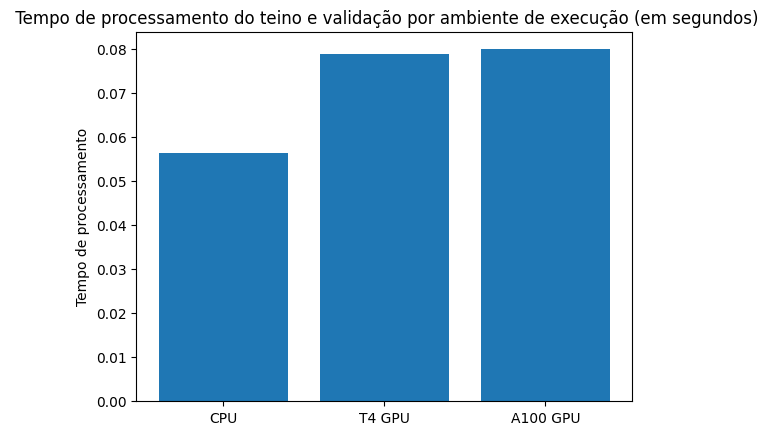

In [ ]:
fig, ax = plt.subplots()

cpu_time = data["CPU"]["execution_time"]
t4_time = data["T4 GPU"]["execution_time"]
a100_time = data["A100 GPU"]["execution_time"]

shapes = [cpu_time, t4_time, a100_time]
labels = ["CPU", "T4 GPU", "A100 GPU"]

ax.bar(labels, [s for s in shapes])
ax.set_ylabel("Tempo de processamento")
ax.set_title(" Tempo de processamento do teino e validação por ambiente de execução (em segundos)")

plt.show()

É possível notar que a CPU apresentou um tempo de processamento menor, em uma média de 10 experimentos, do que as GPUs. A base do scikit-learn não foi desenvolvida para utilizar GPUs (https://scikit-learn.org/stable/faq.html#id12), assim, as operações realizadas não são otimizadas para utilizar uma GPU. Dessa forma, o uso de GPU torna o processo mais lento.

### 6.4.2 Uso de memória

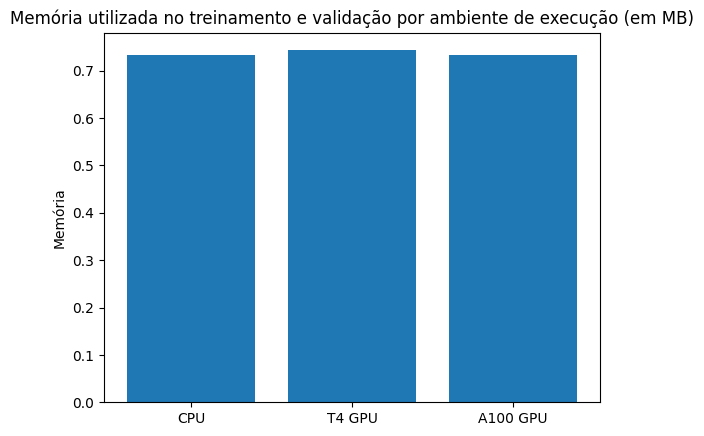

In [ ]:
fig, ax = plt.subplots()

cpu_mem = data["CPU"]["memory_usage"]
t4_mem = data["T4 GPU"]["memory_usage"]
a100_mem = data["A100 GPU"]["memory_usage"]

shapes = [cpu_mem, t4_mem, a100_mem]
labels = ["CPU", "T4 GPU", "A100 GPU"]

ax.bar(labels, [s for s in shapes])
ax.set_ylabel("Memória")
ax.set_title("Memória utilizada no treinamento e validação por ambiente de execução (em MB)")

plt.show()

É possível notar que a CPU e a A100 GPU apresentaram consumo de memória semelhantes e levemente inferiores a T4 GPU. Assim, pode-se concluir que o consumo de memória não mostrou relevância para diferenciar o uso.

Conclusão: A CPU se apresentou como uma melhor solução para este problema por levar menos tempo no processamento.